<b>Authors</b>: Jivesh Ramduny, Ph.D & Arielle Baskin-Sommers, Ph.D

<b>Location</b>: Mechanisms for Disinhibition Lab, Yale University

<b>Resources</b>: Masonic Institute for the Developing Brain, University of Minnesota

<b>Data</b>: Adolescent Brain Cognitive Development (ABCD) Study NDA Baseline Release 4.0

<b>Preprocessing</b>: ABCD-BIDS Community Collection (ABCC)

<b>Aim</b>: We developed two head motion mitigation strategies including motion-ordering and motion-ordering+resampling (i.e., bagging) at the timeseries level to maximise participant inclusivity in consortia datasets (e.g., ABCD Study) as a means to rescue high-motion individuals that would otherwise be discarded. By bootstrapping the motion-limited fMRI timeseries of participants, we are able to rescue some of their data based on the assumption that high-motion participants also have useable or meaningful data.

<b>Version</b>: 06/23/2024

In [2]:
import os
import glob
import nilearn
import warnings
import numpy as np
import pandas as pd
import nibabel as nb
import pingouin as pg
import seaborn as sns
import os.path as path
import statsmodels.api as sm
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


/Users/jiveshramduny/anaconda3/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Standard Approach

In [3]:
all_low_motion_df = pd.read_csv('/Users/jiveshramduny/Downloads/complete_good_recomputedQC_behav_REST1_n5733.csv')
test = all_low_motion_df.query('race_ethnicity == 1 & meanFD <= 0.20')
test


,src_subject_id,Unnamed: 0.1,Unnamed: 0,race_ethnicity,sex,rsfmri_c_ngd_numtrs,rsfmri_c_ngd_meanmotion,rsfmri_c_ngd_stnvols,mean_tSNR,cbcl_scr_syn_external_t,nihtbx_totalcomp_uncorrected,sex_recode,meanFD,scrubbed_ngd_vols,FDSize,TSsize,meanFDR1,scrubbed_ngd_vols_R1
0,NDARINV003RTV85,0,0,1,F,1532,0.150697,1162,29.377575,41,92.0,1,0.143377,1033,1530.0,1530.0,0.066475,355
1,NDARINV007W6H7B,1,1,1,M,1520,0.037013,1494,55.036950,44,96.0,0,0.046327,1472,1520.0,1520.0,0.041123,369
4,NDARINV00NPMHND,4,7,1,F,1532,0.091014,1438,46.986000,47,80.0,1,0.093446,1347,1530.0,1530.0,0.103823,312
6,NDARINV01NAYMZH,6,13,1,M,1532,0.097439,1368,31.301600,50,93.0,0,0.100220,1329,1530.0,1530.0,0.090298,328
7,NDARINV01RGTWD2,7,14,1,F,1532,0.117468,1332,29.985650,61,83.0,1,0.118438,1222,1530.0,1530.0,0.050299,379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3666,NDARINVZV54BWRE,3853,6919,1,M,1149,0.126828,967,32.252800,33,85.0,0,0.107475,1220,1470.0,1470.0,0.136848,280
3668,NDARINVZYC44GB8,3856,6928,1,M,1532,0.142986,1221,28.628600,40,90.0,0,0.147454,1017,1530.0,1530.0,0.111504,310
3671,NDARINVZZ6ZJ2KY,3859,6935,1,F,1532,0.045439,1499,33.902275,57,91.0,1,0.052430,1528,1530.0,1530.0,0.054347,383
3672,NDARINVZZFG6J5U,3860,6937,1,F,1520,0.185023,1295,32.010350,60,81.0,1,0.187116,1165,1520.0,1520.0,0.084358,353


In [4]:
datapath = np.sort(glob.glob('/Users/jiveshramduny/Downloads/white_filtered_timeseries_n3676/*_ses-baselineYear1Arm1_task-rest_bold_atlas-Gordon2014FreeSurferSubcortical_desc-filtered_timeseries.ptseries.nii'))

all_datapath_idlist = [os.path.basename(x).split('-')[1] for x in datapath]
all_data_subs_id = [os.path.basename(x).split('_')[0] for x in all_datapath_idlist]
all_data_common_subs = test['src_subject_id'][test['src_subject_id'].isin(pd.Series(all_data_subs_id))].values

all_rsfMRI_timeseries = []

for sub in all_data_common_subs:
    
    rsfMRI_timeseries = nb.load('/Users/jiveshramduny/Downloads/white_filtered_timeseries_n3676/sub-'+str(sub)+'_ses-baselineYear1Arm1_task-rest_bold_atlas-Gordon2014FreeSurferSubcortical_desc-filtered_timeseries.ptseries.nii').get_fdata()
    all_rsfMRI_timeseries.append(rsfMRI_timeseries)
    

In [5]:
len(all_rsfMRI_timeseries)

2266

Compute the <u>edge-level</u> partial spearman rank correlation ($R_{s}$) between FC and behaviour (e.g., externalising psychopathology [CBCL], cognitive ability [NIH Toolbox]) while treating sex and head motion as covariates for <u>each racial/ethnic group</u> (i.e., White, Black, Hispanic). This is to find out which edge in the connectome shares a significant relationship with behaviour for each group. After obtaining the correlation and its significance for each edge, it is important to correct for multiple comparisons (i.e., we need to correct the $p$ values for the number of edges) using FDR correction as it is less conservative than Bonferroni. In our case where we are using the Gordon 352 parcellation, we are going to apply FDR correction across 61,776 edges.

In [6]:
numROI = 352
best_edge = 5115

rsfMRI_bestroi_nonzero_timeseries = []
TEMP_A = np.arange(numROI * numROI).reshape(numROI, numROI)
TEMP_A2 = np.arange(numROI * numROI).reshape(numROI, numROI)
np.fill_diagonal(TEMP_A, 1)

TEMP_B = TEMP_A[np.triu_indices(numROI, k = 1)]
ROI_dimx = np.where(TEMP_A2 == TEMP_B[best_edge])

for timeseries in range(len(all_rsfMRI_timeseries)):
    
    rsfMRI_bestroi_nonzero_timeseries.append(np.take(all_rsfMRI_timeseries[timeseries], ROI_dimx, axis = 1).squeeze())
    

We can proceed to compute the relationship between FC and behaviour as a function of sample size (N) using the <u>full timeseries</u> of the participants. We refer to this as the **standard approach** where we bootstrap N from a subset of participants (e.g., N=25...) across 500 epochs.

In [7]:
subjects = 25
epochs = 500

all_rssamples = []

bootstrap_REST1_corr = np.zeros((epochs, subjects))

for epoch in range(epochs):
    
    resample_sub = 0
    
    if epoch == 0:
        print("Doing epoch {} of {}...".format(epoch + 1, epochs), end = " ")
        
    else:
        print("{}..".format(epoch + 1), end = " ")
    
    samples = np.random.choice(len(rsfMRI_bestroi_nonzero_timeseries), subjects, replace = False)
    all_rssamples.append(samples)
    
    for sample in samples:
        
        rsbootstrap_timeseries_2d = rsfMRI_bestroi_nonzero_timeseries[sample]
        FC_matrix = np.corrcoef(np.transpose(rsbootstrap_timeseries_2d))
        FisherZ_FC_matrix = np.arctanh(FC_matrix)
    
        #vectorise correlation matrix to select upper triangular matrix
        shape_FisherZ_corr = FisherZ_FC_matrix.shape[0]
        arange_FisherZ_corr, diag = np.triu_indices(shape_FisherZ_corr, 1)
        FisherZ_edges = FisherZ_FC_matrix[arange_FisherZ_corr, diag]
        
        bootstrap_REST1_corr[epoch, resample_sub] = FisherZ_edges
        resample_sub = resample_sub + 1
        

Doing epoch 1 of 500... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 18

In [8]:
model_standard_pval = []
model_standard_coef = []

for epoch in range(epochs):
    
    behav2 = test[['nihtbx_totalcomp_uncorrected', 'sex_recode', 'meanFD']]
    behav2 = pd.DataFrame(np.take(np.array(behav2), all_rssamples[epoch], axis = 0))
    behav2.columns = ['nihtbx_totalcomp_uncorrected', 'sex_recode', 'meanFD']
    
    behav2['FC'] = bootstrap_REST1_corr[epoch, :]
    
    standard_model = pg.partial_corr(data = behav2, x = 'nihtbx_totalcomp_uncorrected', y = 'FC', covar = ['sex_recode', 'meanFD'], method = 'spearman')
    model_standard_pval.append(standard_model['p-val'])
    model_standard_coef.append(standard_model['r'])
    

In [9]:
model_standard_pval = np.array(model_standard_pval).squeeze()
model_standard_coef = np.array(model_standard_coef).squeeze()

min_coef = model_standard_coef.min()
print("min coef:" + str(min_coef))

max_coef = model_standard_coef.max()
print("max coef:" + str(max_coef))

mean_coef = model_standard_coef.mean()
print("mean coef:" + str(mean_coef))

lower_ci = np.percentile(model_standard_coef, q = 2.5)
print("lower ci:" + str(lower_ci))

upper_ci = np.percentile(model_standard_coef, q = 97.5)
print("upper ci:" + str(upper_ci))


min coef:-0.5547809225275787
max coef:0.7174491599044875
mean coef:0.09969724764505702
lower ci:-0.344019796023648
upper ci:0.5354754501269178


## Motion-ordering and Bagging Approaches

In [10]:
all_low_motion_df = pd.read_csv('/Users/jiveshramduny/Downloads/complete_good_recomputedQC_behav_REST1_n5733.csv')
test = all_low_motion_df.query('race_ethnicity == 1 & scrubbed_ngd_vols >= 100')
test


,src_subject_id,Unnamed: 0.1,Unnamed: 0,race_ethnicity,sex,rsfmri_c_ngd_numtrs,rsfmri_c_ngd_meanmotion,rsfmri_c_ngd_stnvols,mean_tSNR,cbcl_scr_syn_external_t,nihtbx_totalcomp_uncorrected,sex_recode,meanFD,scrubbed_ngd_vols,FDSize,TSsize,meanFDR1,scrubbed_ngd_vols_R1
0,NDARINV003RTV85,0,0,1,F,1532,0.150697,1162,29.377575,41,92.0,1,0.143377,1033,1530.0,1530.0,0.066475,355
1,NDARINV007W6H7B,1,1,1,M,1520,0.037013,1494,55.036950,44,96.0,0,0.046327,1472,1520.0,1520.0,0.041123,369
2,NDARINV00BD7VDC,2,2,1,M,1532,0.200699,1119,30.149350,46,92.0,0,0.211218,900,1530.0,1530.0,0.075133,341
3,NDARINV00CY2MDM,3,3,1,M,1532,0.578596,784,25.600100,66,82.0,0,0.569077,506,1530.0,1530.0,0.134064,254
4,NDARINV00NPMHND,4,7,1,F,1532,0.091014,1438,46.986000,47,80.0,1,0.093446,1347,1530.0,1530.0,0.103823,312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3671,NDARINVZZ6ZJ2KY,3859,6935,1,F,1532,0.045439,1499,33.902275,57,91.0,1,0.052430,1528,1530.0,1530.0,0.054347,383
3672,NDARINVZZFG6J5U,3860,6937,1,F,1520,0.185023,1295,32.010350,60,81.0,1,0.187116,1165,1520.0,1520.0,0.084358,353
3673,NDARINVZZJ3A7BK,3861,6938,1,F,1532,0.247100,1014,26.719800,59,99.0,1,0.235161,745,1530.0,1530.0,0.094615,309
3674,NDARINVZZLZCKAY,3862,6939,1,F,1532,0.876012,679,19.561475,62,82.0,1,0.807553,542,1530.0,1530.0,0.234559,238


In [11]:
datapath = np.sort(glob.glob('/Users/jiveshramduny/Downloads/white_filtered_timeseries_n3676/*_ses-baselineYear1Arm1_task-rest_bold_atlas-Gordon2014FreeSurferSubcortical_desc-filtered_timeseries.ptseries.nii'))

all_datapath_idlist = [os.path.basename(x).split('-')[1] for x in datapath]
all_data_subs_id = [os.path.basename(x).split('_')[0] for x in all_datapath_idlist]
all_data_common_subs = test['src_subject_id'][test['src_subject_id'].isin(pd.Series(all_data_subs_id))].values

all_rsfMRI_timeseries = []

for sub in all_data_common_subs:
    
    rsfMRI_timeseries = nb.load('/Users/jiveshramduny/Downloads/white_filtered_timeseries_n3676/sub-'+str(sub)+'_ses-baselineYear1Arm1_task-rest_bold_atlas-Gordon2014FreeSurferSubcortical_desc-filtered_timeseries.ptseries.nii').get_fdata()
    all_rsfMRI_timeseries.append(rsfMRI_timeseries)
    

In [14]:
len(all_rsfMRI_timeseries)

3675

#### Scrubbing

In [17]:
motion_dir = np.sort(glob.glob('/Users/jiveshramduny/Downloads/lowhighmotion_white_fd_concat_n3675/*_desc-filteredincludingFD_merge_motion.txt'))

rssubj_exclusion = []
best_timepoints_size_s1 = []
all_unique_contaminated_indices = []
all_motion_idlist = [os.path.basename(x).split('-')[1] for x in motion_dir]
all_motion_subs_id = [os.path.basename(x).split('_')[0] for x in all_motion_idlist]
all_motion_common_subs = test['src_subject_id'][test['src_subject_id'].isin(pd.Series(all_motion_subs_id))].values

#select head motion threshold to identify contaminated timepoints
threshold = 0.20

#select minimum amount of timepoints to be retained after identifying contaminated timepoints
minTP = 100

#select number of bootstrapped timepoints from the best timepoints
TP = 100

for motion_sub in all_motion_common_subs:
    
    FD = np.loadtxt('/Users/jiveshramduny/Downloads/lowhighmotion_white_fd_concat_n3675/sub-'+str(motion_sub)+'_desc-filteredincludingFD_merge_motion.txt')
    
    #find the indices of the contaminated timepoints with FD > threshold
    FD_thresh = np.asarray(np.where(FD > threshold))
    
    #find the indices of the preceding timepoints to be srubbed from the timeseries
    left_indices = FD_thresh - 1
    #remove the indices less than 0 as indices should always start from zero
    left_nonzero_indices = left_indices[left_indices >= 0]
    
    #find the indices of the first succeeding timepoints to be scrubbed from the timeseries
    right_first_indices = FD_thresh + 1
    #remove the indices of the first succeeding timepoints if they exceed the size of the timepoints
    right_first_in_range_indices = right_first_indices[right_first_indices < FD.shape]
    #find the indices of the second succeeding timepoints to be scrubbed from the timeseries
    right_second_indices = FD_thresh + 2
    #remove the indices of the second succeeding timepoints if they exceed the size of the timepoints
    right_second_in_range_indices = right_second_indices[right_second_indices < FD.shape]
    
    all_contaminated_indices = np.concatenate((FD_thresh, left_nonzero_indices, right_first_in_range_indices, right_second_in_range_indices), axis = None)
    unique_contaminated_indices = np.unique(all_contaminated_indices).astype(int)
    all_unique_contaminated_indices.append(unique_contaminated_indices)
    
    #find the remaining amount of timepoints left after identifying the contaminated timepoints
    best_timepoints_size = np.array(FD).shape[0] - np.array(unique_contaminated_indices).shape[0]
    #store all subjects' remaining amount of timepoints in an array
    best_timepoints_size_s1.append(best_timepoints_size)
    
    #identify the subjects who has less remaining amount of timepoints than the minimum amount of timepoints
    if (best_timepoints_size < minTP):
        rssubj_exclusion.append(motion_sub)


In [18]:
#find the unique subjects to be excluded from REST
unique_subj_exclusion = np.unique(rssubj_exclusion).astype(int)
print("Total number of participants to be excluded for insufficient scrubbed timepoints:" + str(np.array(rssubj_exclusion).shape[0]))
print("Indices participants to be excluded:" + str(unique_subj_exclusion))

#remove the size of the best timepoints for the subjects to be excluded for REST
best_timepoints_s1 = np.delete(best_timepoints_size_s1, unique_subj_exclusion)
print(best_timepoints_s1.shape[0])

#remove the subjects to be excluded from the original 3D array for REST
for item in reversed(list(unique_subj_exclusion)):
    all_rsfMRI_timeseries.pop(item)

print(len(all_rsfMRI_timeseries))

#remove all the unique contaminated indices of the subjects to be excluded for REST
for item in reversed(list(unique_subj_exclusion)):
    all_unique_contaminated_indices.pop(item)

rsbest_unique_contaminated_indices = all_unique_contaminated_indices
print(len(rsbest_unique_contaminated_indices))


Total number of participants to be excluded for insufficient scrubbed timepoints:0
Indices participants to be excluded:[]
3675
3675
3675


In [19]:
numROI = 352
best_edge = 5115

rsfMRI_bestroi_nonzero_timeseries = []
TEMP_A = np.arange(numROI * numROI).reshape(numROI, numROI)
TEMP_A2 = np.arange(numROI * numROI).reshape(numROI, numROI)
np.fill_diagonal(TEMP_A, 1)

TEMP_B = TEMP_A[np.triu_indices(numROI, k = 1)]
ROI_dimx = np.where(TEMP_A2 == TEMP_B[best_edge])

for timeseries in range(len(all_rsfMRI_timeseries)):
    
    rsfMRI_bestroi_nonzero_timeseries.append(np.take(all_rsfMRI_timeseries[timeseries], ROI_dimx, axis = 1).squeeze())
    

### Motion-ordering Approach

In [26]:
subjects = 25
epochs = 500
epochsBag = 500

motion_dir = np.sort(glob.glob('/Users/jiveshramduny/Downloads/lowhighmotion_white_fd_concat_n3675/*_desc-filteredincludingFD_merge_motion.txt'))
remaining_motion_param_REST1_list = np.delete(np.array(motion_dir), unique_subj_exclusion)

all_samples_REST = []
bootstrap_REST1_corr = np.zeros((epochsBag))
bootstrap_REST1 = np.zeros((epochs, subjects))
edges = ((rsfMRI_bestroi_nonzero_timeseries[0].shape[1]**2 - rsfMRI_bestroi_nonzero_timeseries[0].shape[1])) // 2

for epoch in range(epochs):
    
    if epoch == 0:
        print("Doing epoch {} of {}...".format(epoch + 1, epochs), end = " ")
        
    else:
        print("{}..".format(epoch + 1), end = " ")
        
    bootstrap_rsbest_unique_contaminated_indices = []
    bootstrap_samples_REST1 = []
    
    samples = np.random.choice(len(rsfMRI_bestroi_nonzero_timeseries), subjects, replace = False)
    #samples = all_rssamples[epoch]
    remaining_motion_param_REST1_sample = np.take(remaining_motion_param_REST1_list, samples)
    all_samples_REST.append(samples)
    
    for sample in samples:
        
        bootstrap_rsbest_unique_contaminated_indices.append(rsbest_unique_contaminated_indices[sample])
        bootstrap_samples_REST1.append(rsfMRI_bestroi_nonzero_timeseries[sample])
    
    for subREST1 in range(bootstrap_REST1.shape[1]):
        
        #find the top X least contaminated timepoints for each participant for REST
        subREST1_FD = remaining_motion_param_REST1_sample[subREST1]
        load_subREST1_FD = np.loadtxt(subREST1_FD)
        remaining_best_motion_REST1 = np.delete(load_subREST1_FD, bootstrap_rsbest_unique_contaminated_indices[subREST1])
        find_indices_best_motion_REST1 = np.argsort(remaining_best_motion_REST1)[:minTP]
        
        timeseries = np.delete(bootstrap_samples_REST1[subREST1], bootstrap_rsbest_unique_contaminated_indices[subREST1], axis = 0)
        rsfMRI_bootstrap_timeseries_2d = np.take(timeseries, find_indices_best_motion_REST1, axis = 0)
        
        FC_matrix = np.corrcoef(np.transpose(rsfMRI_bootstrap_timeseries_2d))
        FisherZ_FC_matrix = np.arctanh(FC_matrix)
            
        #vectorise correlation matrix to select upper triangular matrix
        shape_FisherZ_corr = FisherZ_FC_matrix.shape[0]
        arange_FisherZ_corr, diag = np.triu_indices(shape_FisherZ_corr, 1)
        FisherZ_edges = FisherZ_FC_matrix[arange_FisherZ_corr, diag]
            
        mean_bootstrap_REST1_corr = FisherZ_edges
        bootstrap_REST1[epoch, subREST1] = mean_bootstrap_REST1_corr
        

Doing epoch 1 of 500... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 18

### Bagging Approach

In [23]:
subjects = 25
epochs = 500
epochsBag = 500

motion_dir = np.sort(glob.glob('/Users/jiveshramduny/Downloads/lowhighmotion_white_fd_concat_n3675/*_desc-filteredincludingFD_merge_motion.txt'))
remaining_motion_param_REST1_list = np.delete(np.array(motion_dir), unique_subj_exclusion)

all_samples_REST = []
bootstrap_REST1_corr = np.zeros((epochsBag))
bootstrap_REST1 = np.zeros((epochs, subjects))
edges = ((rsfMRI_bestroi_nonzero_timeseries[0].shape[1]**2 - rsfMRI_bestroi_nonzero_timeseries[0].shape[1])) // 2

for epoch in range(epochs):
    
    if epoch == 0:
        print("Doing epoch {} of {}...".format(epoch + 1, epochs), end = " ")
        
    else:
        print("{}..".format(epoch + 1), end = " ")
        
    bootstrap_rsbest_unique_contaminated_indices = []
    bootstrap_samples_REST1 = []
    
    samples = np.random.choice(len(rsfMRI_bestroi_nonzero_timeseries), subjects, replace = False)
    remaining_motion_param_REST1_sample = np.take(remaining_motion_param_REST1_list, samples)
    all_samples_REST.append(samples)
    
    for sample in samples:
        
        bootstrap_rsbest_unique_contaminated_indices.append(rsbest_unique_contaminated_indices[sample])
        bootstrap_samples_REST1.append(rsfMRI_bestroi_nonzero_timeseries[sample])
        
    for subREST1 in range(bootstrap_REST1.shape[1]):
        
        #find the top X least contaminated timepoints for each participant for REST
        subREST1_FD = remaining_motion_param_REST1_sample[subREST1]
        load_subREST1_FD = np.loadtxt(subREST1_FD)

        remaining_best_motion_REST1 = np.delete(load_subREST1_FD, bootstrap_rsbest_unique_contaminated_indices[subREST1])
        find_indices_best_motion_REST1 = np.argsort(remaining_best_motion_REST1)[:minTP]
        
        timeseries = np.delete(bootstrap_samples_REST1[subREST1], bootstrap_rsbest_unique_contaminated_indices[subREST1], axis = 0)
        rsfMRI_bootstrap_timeseries_2d = np.take(timeseries, find_indices_best_motion_REST1, axis = 0)
        
        for epochB in range(epochsBag):
            
            #randomly select X amount of timepoints from the top timepoints for each participant
            bootstrap_sample = np.random.choice(rsfMRI_bootstrap_timeseries_2d.shape[0], TP, replace = True)
            bootstrap_timeseries = np.take(rsfMRI_bootstrap_timeseries_2d, bootstrap_sample, axis = 0)
            FC_matrix = np.corrcoef(np.transpose(bootstrap_timeseries))
            FisherZ_FC_matrix = np.arctanh(FC_matrix)
            
            #vectorise correlation matrix to select upper triangular matrix
            shape_FisherZ_corr = FisherZ_FC_matrix.shape[0]
            arange_FisherZ_corr, diag = np.triu_indices(shape_FisherZ_corr, 1)
            FisherZ_edges = FisherZ_FC_matrix[arange_FisherZ_corr, diag]
            
            bootstrap_REST1_corr[epochB] = FisherZ_edges
            
        mean_bootstrap_REST1_corr = np.mean(bootstrap_REST1_corr)
        bootstrap_REST1[epoch, subREST1] = mean_bootstrap_REST1_corr
        

Doing epoch 1 of 500... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 18

In [27]:
model_bagging_pval = []
model_bagging_coef = []

behav_bag = test[['nihtbx_totalcomp_uncorrected', 'sex_recode', 'meanFD']]
behav_bag = pd.DataFrame(np.delete(np.array(behav_bag), unique_subj_exclusion, axis = 0))

for epoch in range(epochs):
    
    behav_bag_samples = pd.DataFrame(np.take(np.array(behav_bag), all_samples_REST[epoch], axis = 0))
    behav_bag_samples.columns = ['nihtbx_totalcomp_uncorrected', 'sex_recode', 'meanFD']
    
    behav_bag_samples['FC'] = bootstrap_REST1[epoch, :]
    
    bagging_model = pg.partial_corr(data = behav_bag_samples, x = 'nihtbx_totalcomp_uncorrected', y = 'FC', covar = ['sex_recode', 'meanFD'], method = 'spearman')
    model_bagging_pval.append(bagging_model['p-val'])
    model_bagging_coef.append(bagging_model['r'])
    

In [28]:
model_bagging_pval = np.array(model_bagging_pval)
model_bagging_coef = np.array(model_bagging_coef)

min_coef = model_bagging_coef.min()
print("min coef:" + str(min_coef))

max_coef = model_bagging_coef.max()
print("max coef:" + str(max_coef))

mean_coef = model_bagging_coef.mean()
print("mean coef:" + str(mean_coef))

lower_ci = np.percentile(model_bagging_coef, q = 2.5)
print("lower ci:" + str(lower_ci))

upper_ci = np.percentile(model_bagging_coef, q = 97.5)
print("upper ci:" + str(upper_ci))


min coef:-0.46402526748009365
max coef:0.6325215906530043
mean coef:0.07298845418081339
lower ci:-0.3619290641385997
upper ci:0.4702240648434695


## Plotting

In [33]:
standard_approach_REST = pd.read_excel('/Users/jiveshramduny/Downloads/standard_bagging_results_n5733.xlsx', sheet_name = 'Bagging_HM_White_NIH')
standard_approach_REST.head(n = 10)


,SAMPLES,LOGSAMPLES,GROUP,SIZE,MINTR,METHOD,BEHAV,COEFFICIENTS
0,25,1.397940,White,3675,Bagging,MIN,NIHToolbox,-0.6200
1,41,1.612784,White,3675,Bagging,MIN,NIHToolbox,-0.3900
2,68,1.832509,White,3675,Bagging,MIN,NIHToolbox,-0.2800
3,112,2.049218,White,3675,Bagging,MIN,NIHToolbox,-0.2000
4,184,2.264818,White,3675,Bagging,MIN,NIHToolbox,-0.1300
5,303,2.481443,White,3675,Bagging,MIN,NIHToolbox,-0.0480
6,499,2.698101,White,3675,Bagging,MIN,NIHToolbox,-0.0640
7,822,2.914872,White,3675,Bagging,MIN,NIHToolbox,-0.0037
8,1355,3.131939,White,3675,Bagging,MIN,NIHToolbox,0.0150
9,2231,3.348500,White,3675,Bagging,MIN,NIHToolbox,0.0430


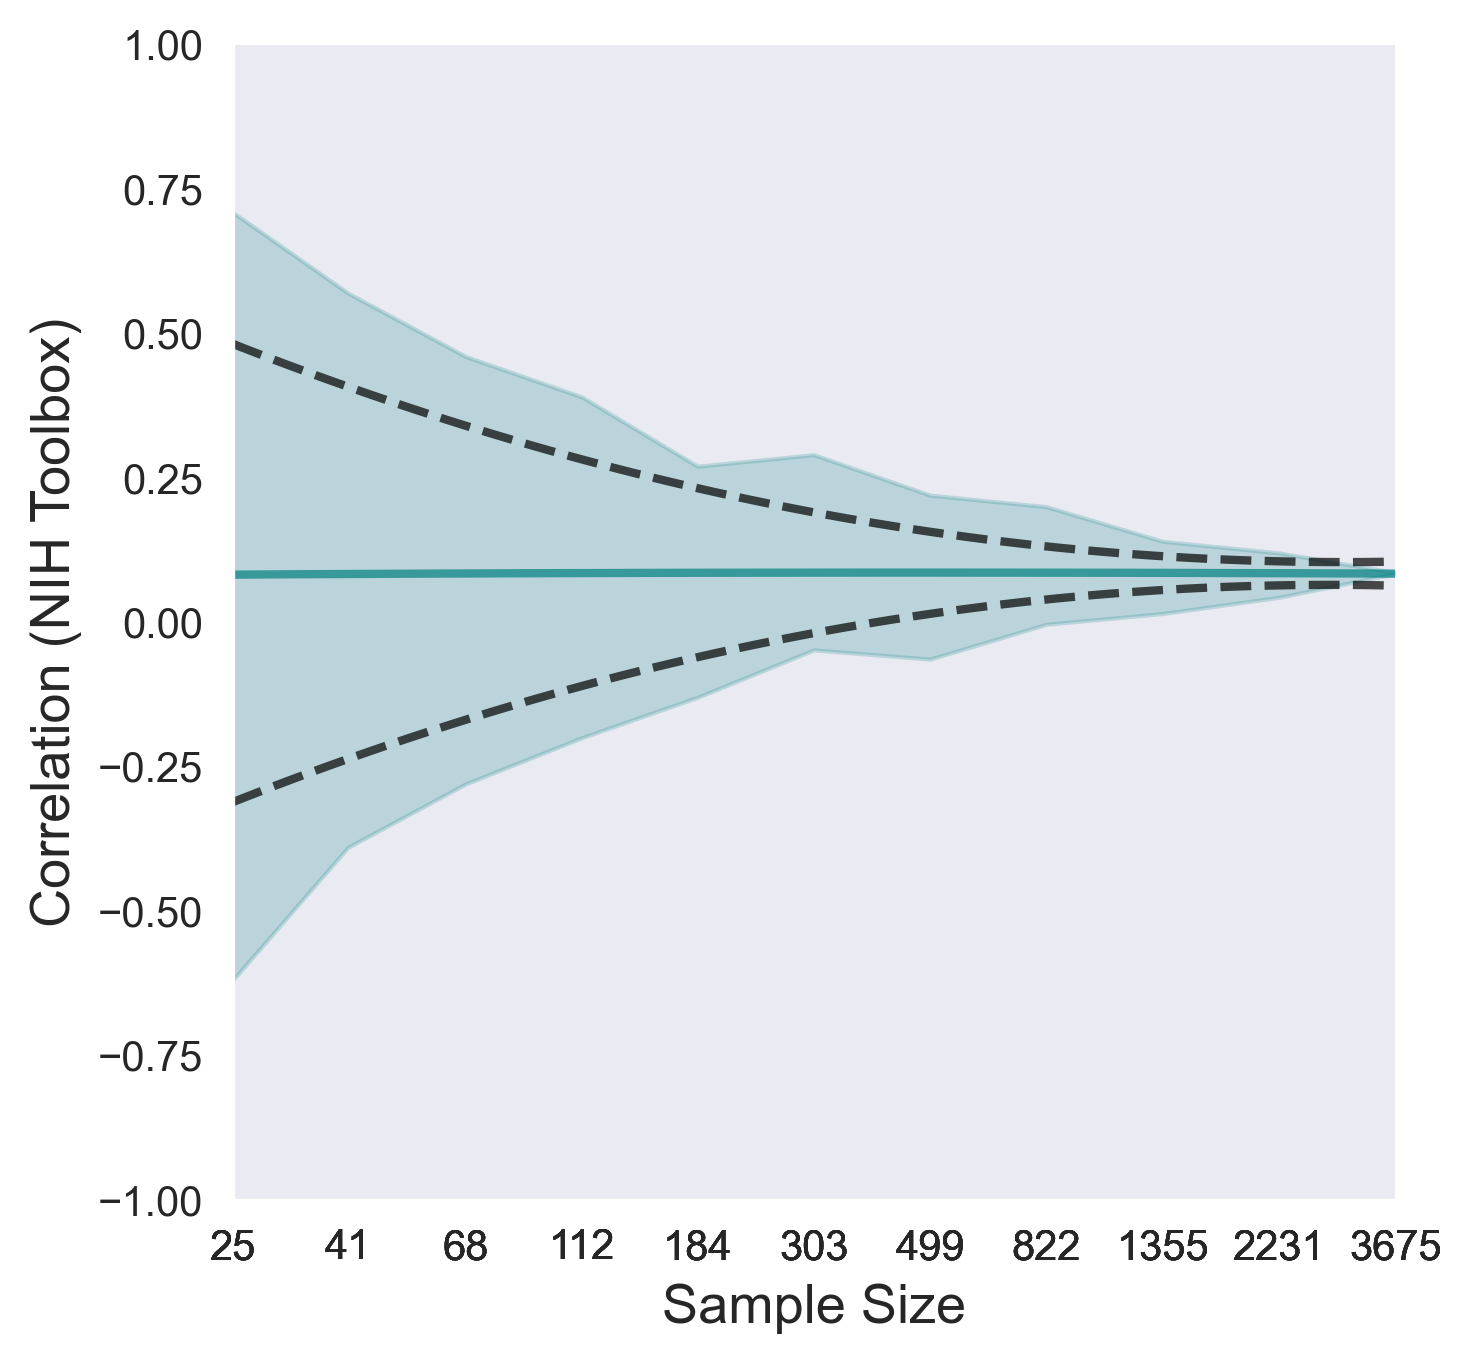

In [34]:
sns.set_style("dark")

_, ax = plt.subplots(figsize=(5, 5))
plt.rcParams['figure.dpi'] = 300

plt.xlim(standard_approach_REST["LOGSAMPLES"].min(), standard_approach_REST["LOGSAMPLES"].max())

plt.ylim(-1.0, 1.0)

for d, ls, c in zip(standard_approach_REST["METHOD"].unique(), ["", "", "-", "--", "--"], ["teal", "teal", "teal", "k", "k"]):
    
    sns.regplot(x = "LOGSAMPLES", y = "COEFFICIENTS", data = standard_approach_REST.loc[standard_approach_REST.METHOD == d], 
                line_kws={"ls":ls, "lw":2, "alpha":0.7}, ax = ax, label = d,
                order = 2, color = c, truncate = False, ci = None, scatter = False)

plt.fill_between(standard_approach_REST["LOGSAMPLES"].unique(), standard_approach_REST[standard_approach_REST["METHOD"] == "MIN"]["COEFFICIENTS"], 
                 standard_approach_REST[standard_approach_REST["METHOD"] == "MAX"]["COEFFICIENTS"],
                 color='teal', alpha = 0.2)    

plt.xlabel("Sample Size", size = 13)
plt.ylabel("Correlation (NIH Toolbox)", size = 13)
plt.xticks(standard_approach_REST["LOGSAMPLES"], standard_approach_REST["SAMPLES"])
sns.despine()


## Calculate area under the curve (AUC)

In [35]:
from sklearn import metrics

Xbagging_LCI = standard_approach_REST['SAMPLES'][standard_approach_REST['METHOD'] == 'LCI']
Ybagging_LCI = standard_approach_REST['COEFFICIENTS'][standard_approach_REST['METHOD'] == 'LCI']
AUCbagging_LCI = metrics.auc(Xbagging_LCI, Ybagging_LCI)

Xbagging_UCI = standard_approach_REST['SAMPLES'][standard_approach_REST['METHOD'] == 'UCI']
Ybagging_UCI = standard_approach_REST['COEFFICIENTS'][standard_approach_REST['METHOD'] == 'UCI']
AUCbagging_UCI = metrics.auc(Xbagging_UCI, Ybagging_UCI)

AUCbagging = AUCbagging_UCI - AUCbagging_LCI

print("AUC for the Bagging Approach:" + str(AUCbagging))


AUC for the Bagging Approach:332.8907
